In [1]:
import os
import re
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer


/home/sandor/.conda/envs/verdi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sandor/.conda/envs/verdi/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
discharge_notes = pd.read_csv('discharge.csv')

In [3]:
def extract_note_fields_simple(note_text):

    service_match = re.search(r"Service:\s*(.*?)\n", note_text, re.IGNORECASE)
    service_value = service_match.group(1).strip() if service_match else None
    
    procedure_match = re.search(r"Major Surgical or Invasive Procedure:\s*\n\s*(\S.*?)\n", note_text, re.IGNORECASE | re.DOTALL)
    procedure_value = procedure_match.group(1).strip() if procedure_match else None

    cc_match = re.search(r"Chief Complaint:\s*\n*(.*?)\n", note_text, re.IGNORECASE | re.DOTALL)
    cc_value = cc_match.group(1).strip() if cc_match else None

    return {
        'service': service_value,
        'chief_complaint': cc_value,
        'major_surgical_procedure': procedure_value
    }

extracted_data = discharge_notes['text'].apply(extract_note_fields_simple).tolist()

new_columns_df = pd.DataFrame(extracted_data)
discharge_notes['Service'] = new_columns_df['service']
discharge_notes['Chief_Complaint'] = new_columns_df['chief_complaint']
discharge_notes['Major_Surgical_Procedure'] = new_columns_df['major_surgical_procedure']

In [2]:
def percentage_of_top_categories(column: str, notes, N=95):
    counts = notes[column].value_counts()
    cumulative_pct = counts.cumsum() / counts.sum() * 100

    top_services = cumulative_pct[cumulative_pct <= N].index

    filtered_df = notes[notes[column].isin(top_services)]

    service_distribution = (
        filtered_df[column]
        .value_counts(normalize=True) * 100
    )

    return service_distribution

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def count_tokens(text):
    tokens = tokenizer.encode(str(text), add_special_tokens=False)
    return len(tokens)

/home/sandor/.conda/envs/verdi/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


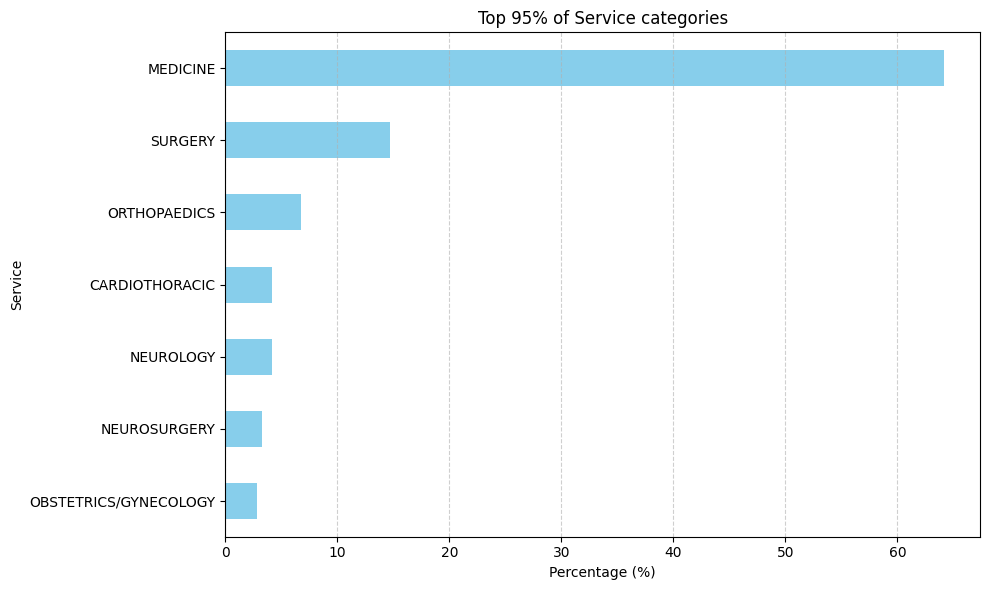

In [5]:
service_distribution = percentage_of_top_categories('Service', discharge_notes)

plt.figure(figsize=(10, 6))
service_distribution.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 95% of Service categories")
plt.xlabel("Percentage (%)")
plt.ylabel("Service")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Por Complaint - Fica muito pulverizado ###

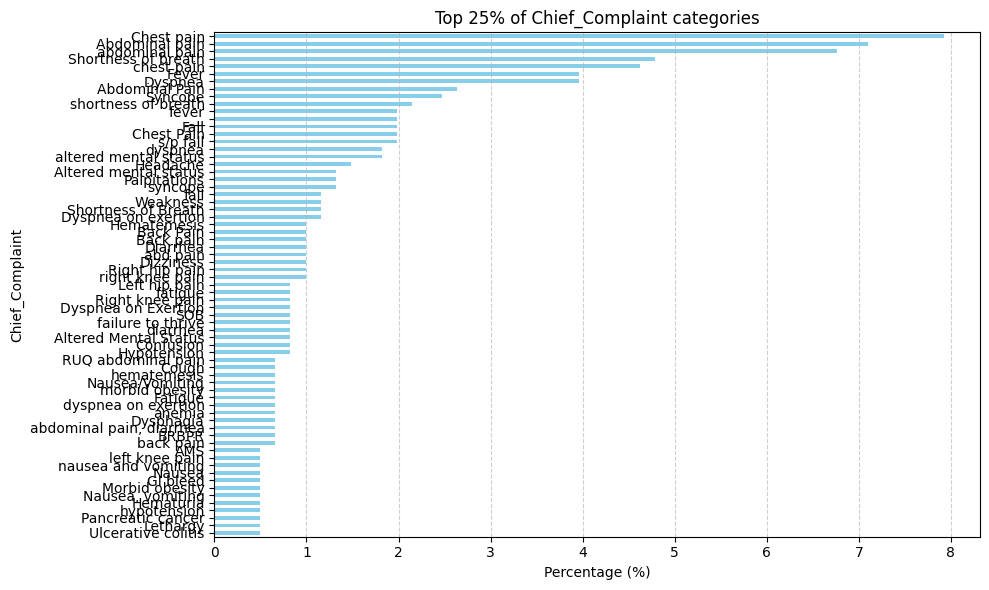

In [ ]:
complaint_distribution = percentage_of_top_categories('Chief_Complaint', discharge_notes, N=25)

plt.figure(figsize=(10, 6))
complaint_distribution.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 25% of Chief_Complaint categories")
plt.xlabel("Percentage (%)")
plt.ylabel("Chief_Complaint")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
discharge_notes["char_count"] = discharge_notes["text"].apply(lambda x: len(str(x)))
discharge_notes["word_count"] = discharge_notes["text"].apply(lambda x: len(str(x).split()))

discharge_notes["token_count"] = discharge_notes["text"].apply(count_tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (2188 > 512). Running this sequence through the model will result in indexing errors


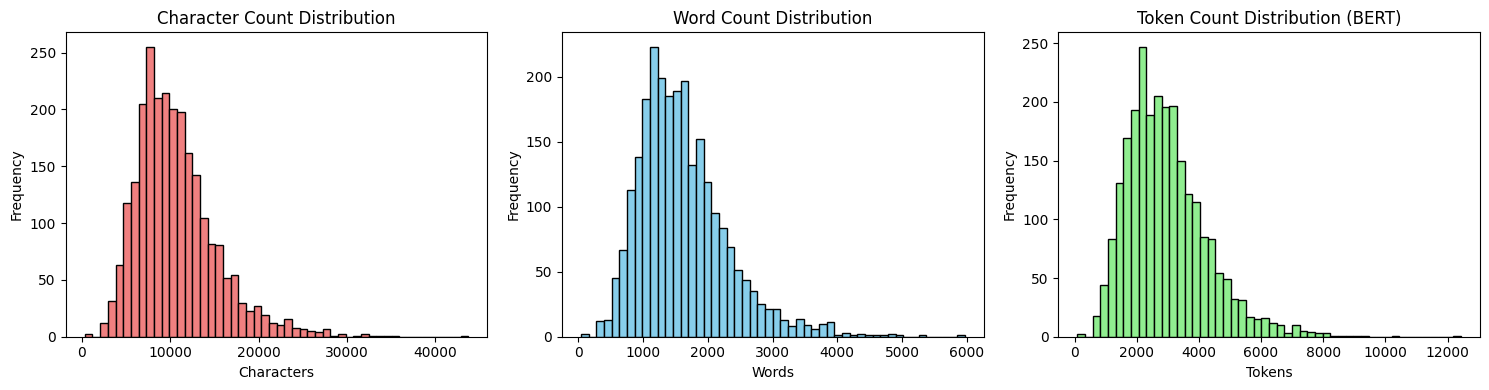

In [16]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(discharge_notes["char_count"], bins=50, color='lightcoral', edgecolor='black')
plt.title("Character Count Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(discharge_notes["word_count"], bins=50, color='skyblue', edgecolor='black')
plt.title("Word Count Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(discharge_notes["token_count"], bins=50, color='lightgreen', edgecolor='black')
plt.title("Token Count Distribution (BERT)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


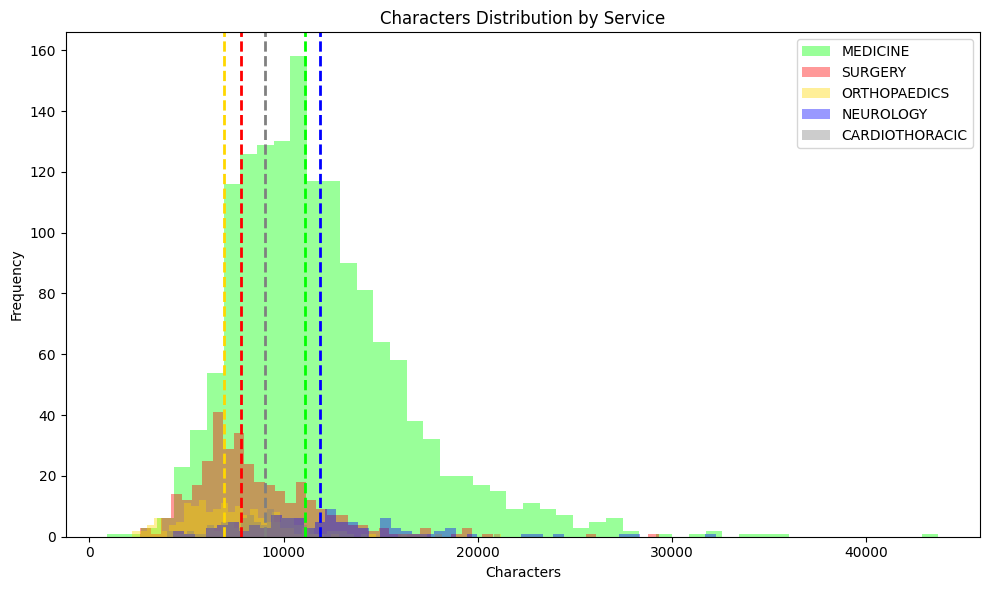

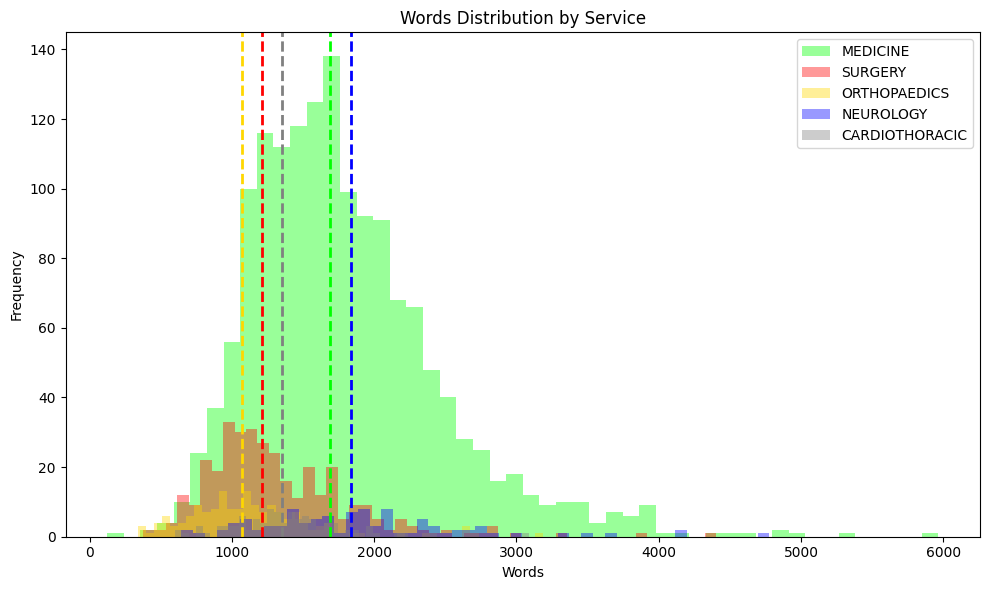

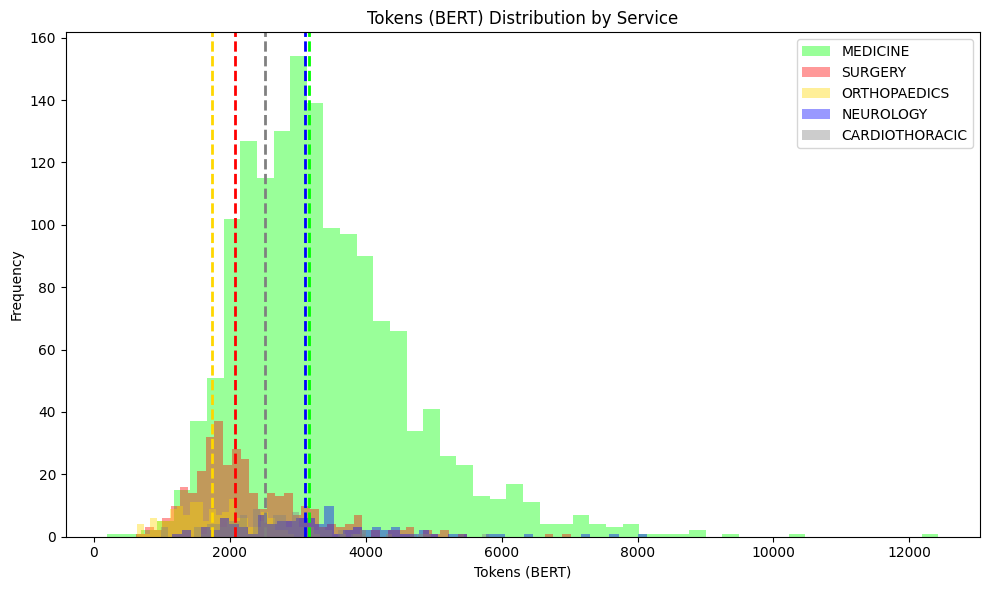

In [39]:
top_services = ["MEDICINE", "SURGERY", "ORTHOPAEDICS", "NEUROLOGY", "CARDIOTHORACIC"]
metrics = ["char_count", "word_count", "token_count"]
metric_labels = ["Characters", "Words", "Tokens (BERT)"]
colors = ["lime", "red", "gold", "blue", "grey"]

subset = discharge_notes[discharge_notes["Service"].isin(top_services)]

for metric, label in zip(metrics, metric_labels):
    plt.figure(figsize=(10, 6))  # bigger figure for each metric
    
    for service, color in zip(top_services, colors):
        data = subset[subset["Service"] == service][metric]
        plt.hist(data, bins=50, alpha=0.4, color=color, label=service)
        
        # Median vertical line
        median_val = np.median(data)
        plt.axvline(median_val, color=color, linestyle='--', linewidth=2)
    
    plt.title(f"{label} Distribution by Service")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Summary statistics for token_count ===


,token_count
count,2500.000000
mean,2964.053200
std,1306.608254
min,92.000000
50%,2774.000000
80%,3917.400000
90%,4605.200000
95%,5342.100000
99%,7204.130000
max,12427.000000



=== Percentile cutoffs ===
80% of texts have ≤ 3917 token count
90% of texts have ≤ 4605 token count
95% of texts have ≤ 5342 token count
99% of texts have ≤ 7204 token count


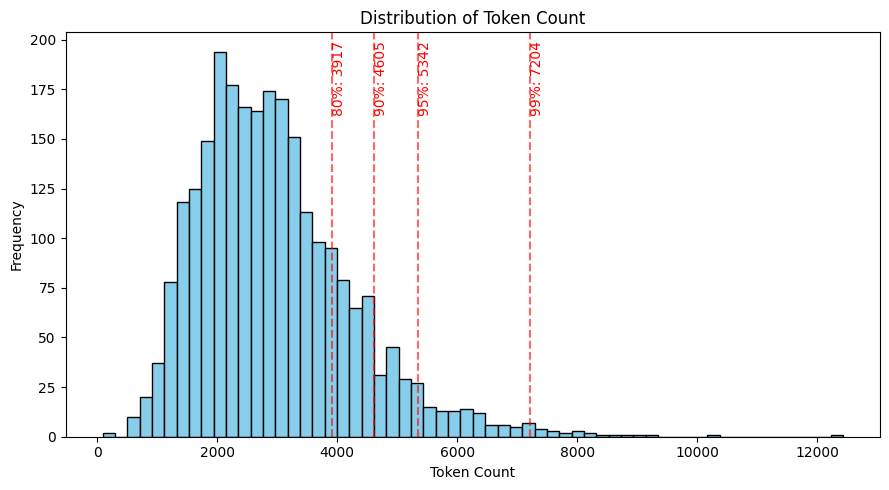


=== Proportion of long texts ===
99.92% of texts exceed 512 token count
97.92% of texts exceed 1024 token count


In [ ]:
def analyze_text_length(df, col="token_count", percentiles=[0.8, 0.9, 0.95, 0.99], thresholds=[512, 1024]):
    """
    Analyze and visualize text length distribution (chars, words, or tokens).
    
    Steps:
    1. Summary statistics with key percentiles
    2. Percentile cutoffs (print 80%, 90%, 95%, 99%)
    3. Histogram with percentile lines
    4. Proportion of texts above thresholds (e.g., 512, 1024)
    """

    data = df[col].dropna()

    print(f"\n=== Summary statistics for {col} ===")
    display(df[[col]].describe(percentiles=percentiles))

    print("\n=== Percentile cutoffs ===")
    for p in percentiles:
        cutoff = np.percentile(data, p * 100)
        print(f"{int(p*100)}% of texts have ≤ {int(cutoff)} {col.replace('_', ' ')}")

    plt.figure(figsize=(9, 5))
    plt.hist(data, bins=60, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col.replace('_', ' ').title()}")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel("Frequency")

    for p in percentiles:
        val = np.percentile(data, p * 100)
        plt.axvline(val, color='red', linestyle='--', alpha=0.6)
        plt.text(val, plt.ylim()[1]*0.8, f"{int(p*100)}%: {int(val)}", rotation=90, color='red')

    plt.tight_layout()
    plt.show()

    print("\n=== Proportion of long texts ===")
    for t in thresholds:
        over_t = (data > t).mean() * 100
        print(f"{over_t:.2f}% of texts exceed {t} {col.replace('_', ' ')}")

analyze_text_length(discharge_notes, col="token_count")


### BHC ###

In [3]:
bhc_notes = pd.read_csv('mimic-iv-bhc.csv')

Token indices sequence length is longer than the specified maximum sequence length for this model (1922 > 512). Running this sequence through the model will result in indexing errors


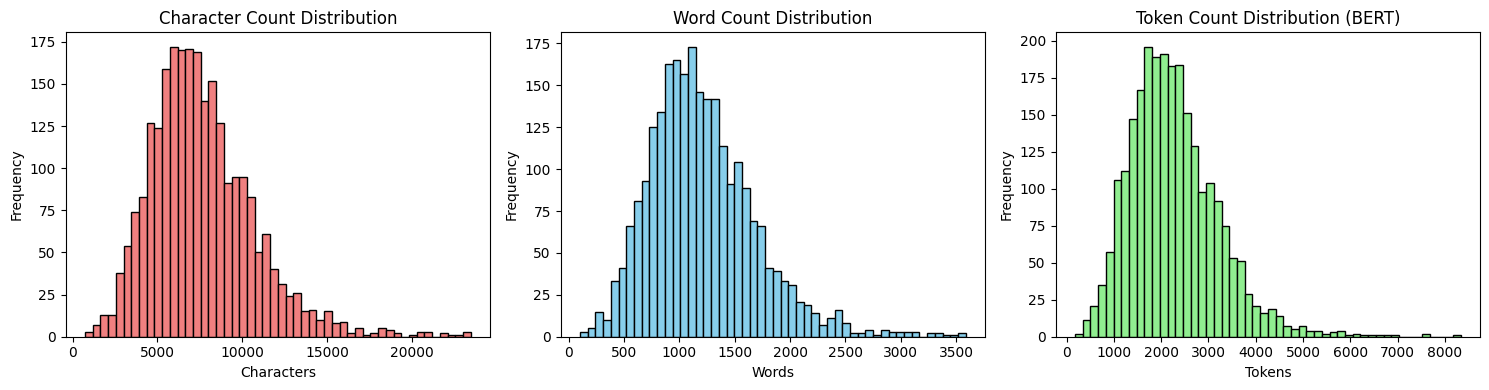

In [5]:
bhc_notes["input_char_count"] = bhc_notes["input"].apply(lambda x: len(str(x)))
bhc_notes["input_word_count"] = bhc_notes["input"].apply(lambda x: len(str(x).split()))

bhc_notes["input_token_count"] = bhc_notes["input"].apply(count_tokens)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(bhc_notes["input_char_count"], bins=50, color='lightcoral', edgecolor='black')
plt.title("Character Count Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(bhc_notes["input_word_count"], bins=50, color='skyblue', edgecolor='black')
plt.title("Word Count Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(bhc_notes["input_token_count"], bins=50, color='lightgreen', edgecolor='black')
plt.title("Token Count Distribution (BERT)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


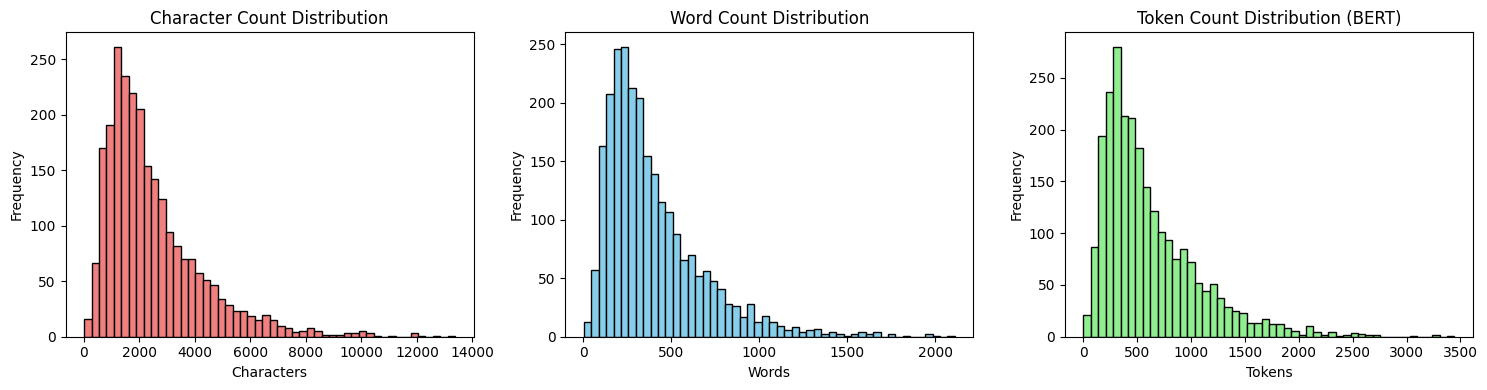

In [6]:
bhc_notes["target_char_count"] = bhc_notes["target"].apply(lambda x: len(str(x)))
bhc_notes["target_word_count"] = bhc_notes["target"].apply(lambda x: len(str(x).split()))

bhc_notes["target_token_count"] = bhc_notes["target"].apply(count_tokens)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(bhc_notes["target_char_count"], bins=50, color='lightcoral', edgecolor='black')
plt.title("Character Count Distribution")
plt.xlabel("Characters")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(bhc_notes["target_word_count"], bins=50, color='skyblue', edgecolor='black')
plt.title("Word Count Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(bhc_notes["target_token_count"], bins=50, color='lightgreen', edgecolor='black')
plt.title("Token Count Distribution (BERT)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()